> Transformer
    
    발표 당시엔 NLP task를 위한 모델이었음
    
    기존 RNN 기반의 encoder-decodedd 구조에서 RNN 모듈을 버리고 attetion만을 이용하여 번역 등의 task를 수행하는 모델 구조
    
     embeding된 input sequence를 넣어서 encoder로 transform을 하고 그 transform된 embeding을 decoder에 넣어서 decoder에 들어간 input과 attention을 한 번 더 수행하여 출력하는 구조(첫 번째 사진 참고)
     
     

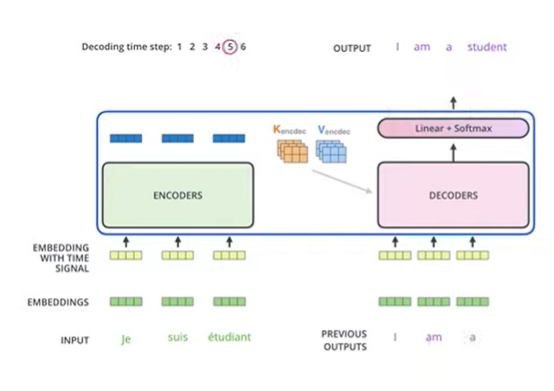

> DETR(DEtection with TRansformer)

    Transformer와 이분 매칭(Bipartile-matching) 기반의 새로운 detection 구조
    
    Object detection을 direct set prediction의 문제로 접근하며, end-to-end 모델로서 geometric prior(RPN,NMS같이 hand-crafted 엔지니어링)가 필요하지 않음
    
    구조적으로 간결함에도 다른 task에 확장성이 높고(e.g. panoptic segmentation), attetion mechanism에 의해 global한 정보를 이용함에 따라 큰 물체 탐지에 대해서 Faster R-CNN에 비해 더 높은 성능을 보여줌
    
    아래 그림 : 이미지를 CNN에 태운 결과인 set of image features 즉, feature map을 가지고 transformer encoder-decoder에서 attention 기반의 학습을 수행하고, transformer encoder-decoder와 set-prediction을 사용하기 때문에 NMS가 필요없음
    중복 없는 set 기반 예측이 진행될 것

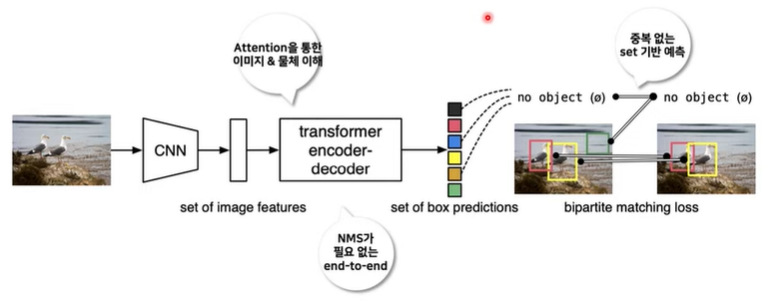

> detail of DETR

    아래 그림의 1~2번을 보면
    : encoder는 attetion mechanism을 기반으로 feature map의 pixel과 pixel간의 관계를 학습, attention mechanism을 기반으로 하기 때문에 가능함.
    
    Locality 중심의 CNN과 다르게 global한 정보를 학습함으로써 이미지를 이해하고 특히 object detection task에 맞게 학습됨으로써 이미지 내의 object의 위치, 관계 등 도한 학습하게 됨
     
    1. 이미지를 Transformer 입력 형태로 변환
    2. Positional Encoding. Transformer architecture와 동일하게 positional encoding을 더하여 입력
    3. Self-Attention. encoder나 decoder에 사용되는 attention mechanism은 입력된 각 픽셀들 간 어떠한 관계가 있는지를 global하게 학습. pixel을 전부 다 봄
    4. FFN. output에 대한 nermalization 및 학습 보조
    
    두 번째 사진, 세 번째 사진 : 
    input 같은 경우는 image를 CNN Backbone(논문에서는 ResNet)에 태워서 feture map을 얻음
    
    얻은 feature map을 1x1 convolution layer에 태워, 미리 설정한 토큰 임베딩 차원(d=256)으로 축소
    
    최종적으로 sequential한 token을 마련해주기 위해서 dxHW로 flatten 수행. 어떤 특정 pixel위치에 있는 모든 channel들을 가져오게 됨. 그럼 오른쪽처럼 하나의 token의 차원은 d차원의 vector가 됨. 결과적으로 transformer에 입력으로 사용할 수 있는 sequence를 얻음
    
    

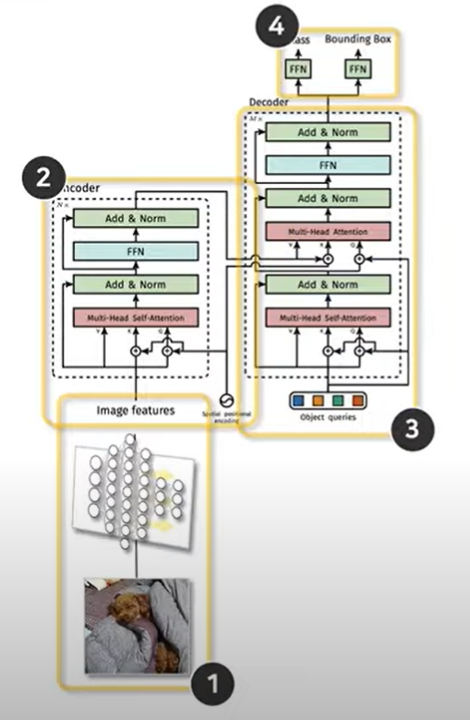
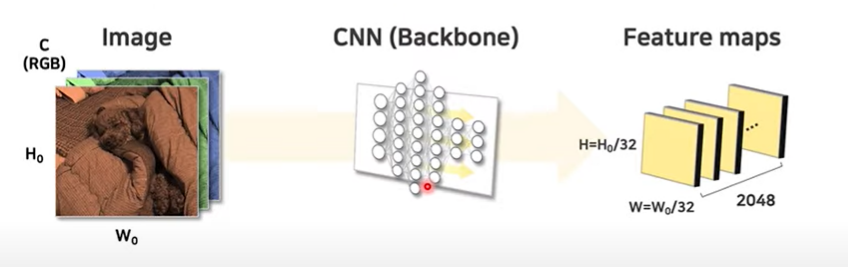
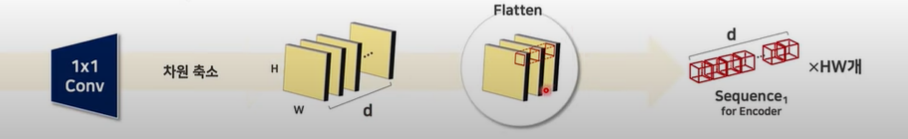

---

- Transformer의 encoder는 permutation-invariant하기 때문에 토큰 간 차이를 나타낼 수 있도록 positional encoding이 필요

> Decoder

    어떠한 입력값을 받아 이미지 내에 존재하는  object의 클래스 및 위치를 출력하는 것

    permutation invariant한 transformer의 특성 때문에 입력값이 서로 달라야 서로 다른 출력값(물체 예측)을 뱉어낼 수 있으므로, 학습이 가능한 positional encoding을 랜덤하게 초기화하여 입력값으로 사용, 단 decoder는 모든 것이 set이므로 positional embedding이라는 것은 의미가 없음
    set prediction 즉, 순서같은 개념이 중요한 것이 아니라 병렬적이고 독립적으로 학습이 수행되기 때문.
    
    object query는 곧 정보를 담기 위한 그릇(slot)으로 생각할 수 있고
    Decoder의 Encoder-decoder attention을 통해 이미지의 어느 부분을 위주로 봐야할 지(물체가 어느 위치에 있을 확률이 높을 지), self-attention을 통해 자신들의 역할을 어떻게 분배하여 최적의 일대일 매칭을 수행할 수 있을 지를 학습하게 됨
    
    두 번째 사진
    : 이미지가 보물지도라 하고 이미지에 속한 보물들을 object라 해보자. object query들은 보물 사냥꾼이라 하자. 처음에는 random initialization되는 것처럼 일단 정보가 없으니 아무 데나 가게 된다. 
    이 상황에서 이미지를 해석하는 어떤 사람이 "보물이 이쯤에 있을 거다"라고 학습을 하게 되고, 이게 encoder의 역할이고, 그러면 이미지에서 대략적인 보물의 위치의 가닥이 잡히게 되고, 보물 사냥꾼들은 첫 번째로 이 정보를 통해 보물이 어디쯤에 있을 거다라는 정보를 학습하고 "내가 이미 찾았으니 너는 다른 곳을 찾아봐라"라는 self-attention,관계적인 모델링을 학습하게 됨.
    이상적으로는 보물지도에 보물이 다섯개가 있었기 때문에 마찬가지로 보물사냥꾼도 다섯명만 남고 나머지는 보물을 찾지 못하는, 즉 no object로 예측을 하는 과정을 수행하는게 decoder임.곧 object query의 역할임
    
    그렇게 decoder에서 object query가 학습이 되고 학습이 된 object query를 FFN에 태우게 됨. 

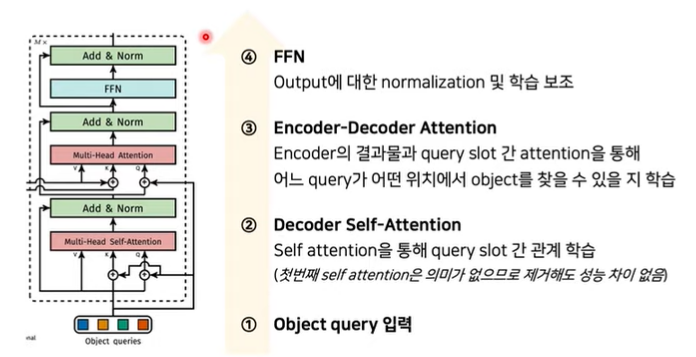
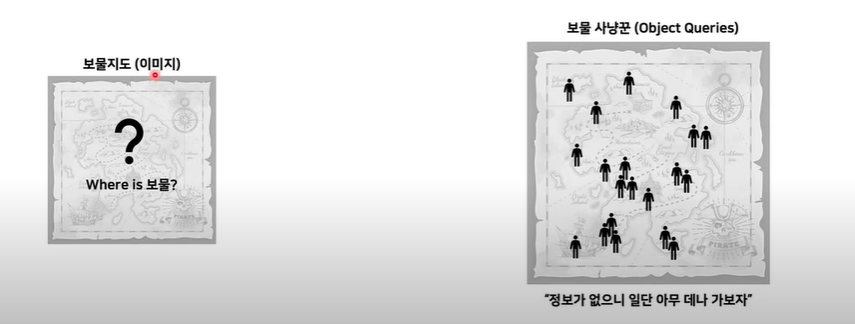

> DETR VS Faster R-CNN

    Faster R-CNN은 RPN(Region Proposal Network)과 NMS(Non-Maximum Supression)을 거쳐 최종적인 후보 위치를 예측한 후, 해당 지역들에 대해 다시 한 번 detection을 수행하는 복잡한 pipeline을 가지고 있음
    
    이에 반해 DETR은 이미지에 관하여 직접적이고 절대적인 방식으로 box-set을 예측함으로써 NMS와 같은 hand-crafted 과정을 사용하지 않아 end-to-end 구조를 구축할 수 있음

> 이분 매칭

    Direct set prediction에서 중요한 두가지 요소는
    1. 예측과 Ground Truth 사이에 중복이 없는 일대일 매칭을 가능케 해야 하며
    2. 한 번의 추론에서 object set을 예측하고 그들의 관계를 모델링 할 수 있어야 한다. 
    이를 위해 가장 적합한 것이 transformer의 attention mechanism이라고 할 수 있음
    transformer의 encoder,decoder 구조를 이용해서 구축한 DETR 모델이 결과를 잘 뽑을 수 있었을 것.
    
    ### 이분매칭
    첫 번째 사진 : 네 명(A~D)이 일(1~4)를 할당받아야 한다고 할 때 기준이 작업능률표가 됨. 작업 능률표를 기반으로 했을 때 각 엔지니어들에게 어떠한 일들을 할당했을 때 최선인가를 푸는 task. 이때 사용되는 게 이분매칭 알고리즘인데, 일대일로 중복이 허용되지 않는 matching이 이루어짐
    
    앞서 object query들이 하나의 slot이라고 하면 각 slot들은 예측값을 뱉을 것이고 이를 ground truth랑 어떻게 매칭을하여 학습을 해야하는지? -> 이분 매칭
    
    여기서 object query가 A~D라고 생각하면 되고 ground truth가 1~4가 될 것
    
    이때 작업능률표에서 값은 어떻게 산출되는 것인가?
    두 번째 사진의 값을 이용하게 됨
    Lmatch값을 예측 순열과 ground truth 순열 간의 비교를 통해 가장 최적의 일대일 매칭을 수행을 해주게 되는 matching을 수행하게 됨
    
    두 번째 사진에서 클래스 예측 cost는 해당 순열이 있다고 했을 때 그 순열이 예측한 클래스의 확률값을 그대로 사용, 따라서 클래스 예측 cost가 높아지는 순열을 찾게 될 것
    
    두 번째 사진에서 Lbox 같은 경우는 실제 object가 있다고 판단한 box의 좌표또한 유사해야 함. 이때 box 좌표 예측 cost는 GIoU Loss를 사용함.
    GIoU Loss ? IOU Loss를 개선한 개념 - 두 영역이 겹치지 않는 경우에도 loss를 정의해 학습에 이용할 수 있음
    
    결과적으로는 object query가 순열로 나왔다고 했을 때 이 순열을 어떻게 돌려서 최적의 순열을 만들었을 때 gound trurh 순열과 매칭했을 때 Lmatch Loss가 가장 적은지 계산하게 됨

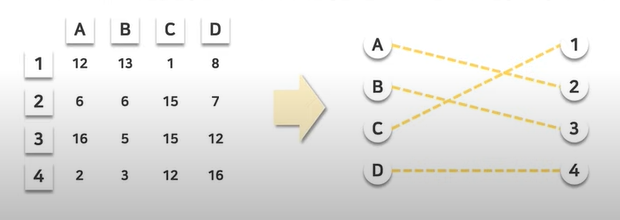
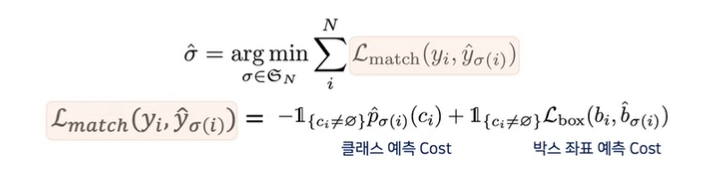
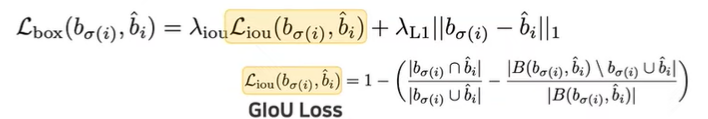

> Experiments

    ### DETR vs Faster R-CNN
    AP : + 0.9
    APs(작은 물체에 대한 AP score) : - 3.5
    APl( 큰 문체에 대한 AP score) : + 6.3
    
    APs는 왜 낮을까?

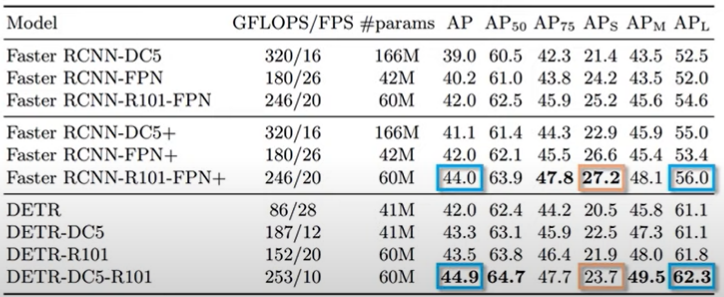
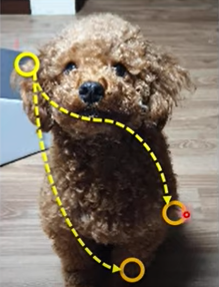